# Libraries


In [1]:
import pandas as pd
#pyforest auto-imports
import warnings
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import resample
from pandas_profiling import ProfileReport
#import pyforest
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV as RFECV_SKYLEARN
pd.options.display.max_columns = 100
#pd.set_option('display.max_columns', None)
from IPython.display import Audio, display
def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

# Tables

In [2]:
#Import key_table
rain_aus = pd.read_csv("C:/Users/user/Documents/1. GitHub/Projeto 4 - Itau/case_guide/data/rain_data_aus.csv")
rain_aus = rain_aus.rename(columns={"amountOfRain": "amntraintmrw"})
rain_aus['raintoday'].replace({'No': 0, 'Yes': 1},inplace = True)
rain_aus['raintomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)
rain_aus.head()


# Import side_tables and concatenate in one
wind1 = pd.read_csv("C:/Users/user/Documents/1. GitHub/Projeto 4 - Itau/case_guide/data/wind_table_01.csv")
wind2 = pd.read_csv("C:/Users/user/Documents/1. GitHub/Projeto 4 - Itau/case_guide/data/wind_table_02.csv")
wind3= pd.read_csv("C:/Users/user/Documents/1. GitHub/Projeto 4 - Itau/case_guide/data/wind_table_03.csv")
wind4 = pd.read_csv("C:/Users/user/Documents/1. GitHub/Projeto 4 - Itau/case_guide/data/wind_table_04.csv")
wind5 = pd.read_csv("C:/Users/user/Documents/1. GitHub/Projeto 4 - Itau/case_guide/data/wind_table_05.csv")
wind6 = pd.read_csv("C:/Users/user/Documents/1. GitHub/Projeto 4 - Itau/case_guide/data/wind_table_06.csv")
wind7 = pd.read_csv("C:/Users/user/Documents/1. GitHub/Projeto 4 - Itau/case_guide/data/wind_table_07.csv")
wind8 = pd.read_csv("C:/Users/user/Documents/1. GitHub/Projeto 4 - Itau/case_guide/data/wind_table_08.csv")
wind = pd.concat([wind1, wind2, wind3, wind4, wind5, wind6, wind7, wind8])

#Correct merged side_tables
cont = 2
for col in wind.columns[8:14]:
    wind.loc[~wind[col].isnull(), wind.columns[cont]] = wind.loc[~wind[col].isnull(), col]
    cont +=1
wind = wind.drop(['windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm'], axis=1)

allDone()

## Correct

In [3]:
#Merge all tables and apply conditions to correct it
rain_merge = pd.merge(left=rain_aus, right=wind, how='left', on=['date', 'location'])
rain_merge['date'] = pd.to_datetime(rain_merge['date'].str.strip(), format='%Y/%m/%d')
rain_merge.loc[(rain_merge.amntraintmrw < 0.4),'amntraintmrw']=0
#Duplicates
    #rain_merge.groupby(rain_merge.columns.tolist(),as_index=False).size())

allDone()
# %% Correct More
#Correct type from columns
rain_merge['wind_gustdir'] = rain_merge['wind_gustdir'].astype(str)
rain_merge['wind_dir9am'] = rain_merge['wind_dir9am'].astype(str)
rain_merge['wind_dir3pm'] = rain_merge['wind_dir3pm'].astype(str)
#turn it into a scale
encoder = LabelEncoder()
encoder.fit(rain_merge['wind_gustdir'])
#transform
rain_merge['wind_gustdir'] = encoder.transform(rain_merge['wind_gustdir'])
rain_merge['wind_dir9am'] = encoder.transform(rain_merge['wind_dir9am'])
rain_merge['wind_dir3pm'] = encoder.transform(rain_merge['wind_dir3pm'])

# see min and max from table
print(rain_merge['date'].min())
print(rain_merge['date'].max())

allDone()

2007-11-01 00:00:00
2017-06-25 00:00:00


## Finish your new table

In [4]:

#Create a table by your current season (apply one month ago + actual month + next month)
seasoned_rain = rain_merge[(rain_merge['date'].dt.month == 5) | (rain_merge['date'].dt.month == 6) | (rain_merge['date'].dt.month == 7)]
seasoned_rain = seasoned_rain[~(seasoned_rain['date'].dt.year <= 2007)]
#seasoned_rain = seasoned_rain[~(seasoned_rain['date'].dt.year >= 2017)]

#Your pipeline to clean your data for your problem and manage it:
seasoned_rain = seasoned_rain.drop(['amntraintmrw', 'modelo_vigente'], axis=1)
#seasoned_rain.drop(['raintomorrow', 'amntraintmrw', 'modelo_vigente', 'temp', 'temp9am', 'temp3pm', 'humidity'], axis=1)


# %% See result
print(seasoned_rain['raintomorrow'].value_counts())
print(seasoned_rain.info())
seasoned_rain


0    33269
1    11132
Name: raintomorrow, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44401 entries, 150 to 164385
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              44401 non-null  datetime64[ns]
 1   location          44401 non-null  object        
 2   mintemp           44162 non-null  float64       
 3   maxtemp           44302 non-null  float64       
 4   rainfall          43986 non-null  float64       
 5   evaporation       23971 non-null  float64       
 6   sunshine          20980 non-null  float64       
 7   humidity9am       43789 non-null  float64       
 8   humidity3pm       42987 non-null  float64       
 9   pressure9am       40019 non-null  float64       
 10  pressure3pm       40029 non-null  float64       
 11  cloud9am          27543 non-null  float64       
 12  cloud3pm          26186 non-null  float64       
 13  temp9am           

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm
150,2009-05-01,Albury,1.8,17.0,0.0,NaN,NaN,77.0,44.0,1026.0,1023.2,NaN,NaN,7.2,16.3,0.0,0,22.400000,54.8,6,18.280679,12,19.0,16,15,0.0,7.0
151,2009-05-02,Albury,7.2,19.2,0.0,NaN,NaN,81.0,49.0,1026.9,1024.0,8.0,4.0,10.1,19.1,0.0,0,25.040000,60.8,12,10.351155,12,22.0,1,13,7.0,6.0
152,2009-05-03,Albury,4.6,18.9,0.0,NaN,NaN,75.0,51.0,1028.7,1025.9,NaN,NaN,10.6,18.5,0.0,0,24.680000,63.2,12,11.468518,8,15.0,3,10,4.0,7.0
153,2009-05-04,Albury,4.2,19.1,0.0,NaN,NaN,86.0,44.0,1029.8,1027.3,NaN,NaN,9.6,18.8,0.0,0,2.733304,54.8,18,8.019610,13,19.0,1,15,6.0,13.0
154,2009-05-05,Albury,5.2,18.8,0.0,NaN,NaN,71.0,47.0,1031.4,1028.1,NaN,NaN,10.3,18.4,0.0,0,24.560000,58.4,7,7.733560,2,15.0,16,9,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164381,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,0.0,0,32.360000,27.2,9,19.715976,6,22.0,9,3,13.0,9.0
164382,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,0.0,0,34.280000,30.8,12,0.985551,3,37.0,9,14,9.0,9.0
164383,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,0.0,0,34.280000,30.8,12,0.985551,3,37.0,9,14,9.0,9.0
164384,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0.0,0,34.400000,30.8,15,4.381481,9,28.0,10,3,13.0,7.0


In [5]:
seasoned_rain.columns

Index(['date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation',
       'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm',
       'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'raintoday',
       'raintomorrow', 'temp', 'humidity', 'precipitation3pm',
       'precipitation9am', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm'],
      dtype='object')

In [6]:
allDone()

# MODEL IT: PyCaret

In [7]:
from pycaret.classification import *
clf1 = setup(data = seasoned_rain, target = 'raintomorrow'
             , silent = True
             , log_experiment = True, experiment_name = 'rain_tomorrow_exp'
             , log_plots = True, log_profile = True, log_data = True
             #, profile = True #, profile_kwargs = True
             , train_size = 0.3
             #, sampling = True
             , numeric_imputation = 'median', categorical_imputation = 'constant'
             , normalize = True, normalize_method = 'zscore'
             , handle_unknown_categorical = True, unknown_categorical_method = 'most_frequent'
             , fix_imbalance = True
             , transformation = True, transformation_method = 'yeo-johnson' # transformation_method = ‘quantile’
             , combine_rare_levels = True, rare_level_threshold = 0.1
             , feature_selection = True, feature_selection_threshold = 0.8
             , remove_multicollinearity = True, multicollinearity_threshold = 0.95
             , pca = False
             , ignore_low_variance = True
             , fold_strategy = 'stratifiedkfold'
             , fold = 10
             , use_gpu = False
             , n_jobs = 5 #n_jobs = -1
              )

logs = get_logs(save=True)

allDone()

,Description,Value
0,session_id,4267
1,Target,raintomorrow
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(44401, 27)"
5,Missing Values,True
6,Numeric Features,21
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


##  Set Unseen Data

In [8]:
data = seasoned_rain
data.shape

(44401, 27)

In [9]:
data = seasoned_rain.sample(frac=0.95, random_state=786)
data_unseen = seasoned_rain.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
allDone()

Data for Modeling: (42181, 27)


In [10]:
print('Unseen Data For Predictions ' + str(data_unseen.shape))
logs = get_logs(save=True)

allDone()

Unseen Data For Predictions (2220, 27)


## Choose Models

In [11]:
# return best model
best = compare_models(sort = 'AUC') #default is 'Accuracy'
allDone()
print(best)
allDone()

save_model(best, 'best')
logs = get_logs(save=True)
allDone()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8486,0.8950,0.6559,0.7229,0.6876,0.5880,0.5894,0.8680
et,Extra Trees Classifier,0.8520,0.8949,0.6287,0.7496,0.6833,0.5878,0.5920,1.1230
lightgbm,Light Gradient Boosting Machine,0.8471,0.8880,0.6231,0.7351,0.6744,0.5754,0.5789,0.4860
xgboost,Extreme Gradient Boosting,0.8449,0.8838,0.6146,0.7327,0.6682,0.5680,0.5719,1.9270
gbc,Gradient Boosting Classifier,0.8294,0.8725,0.6409,0.6725,0.6562,0.5429,0.5433,1.7590
lr,Logistic Regression,0.7936,0.8703,0.7806,0.5689,0.6580,0.5154,0.5287,1.8340
lda,Linear Discriminant Analysis,0.7939,0.8698,0.7812,0.5694,0.6585,0.5162,0.5296,0.5550
ada,Ada Boost Classifier,0.8100,0.8479,0.6358,0.6239,0.6297,0.5019,0.5021,0.6760
knn,K Neighbors Classifier,0.7068,0.8070,0.7974,0.4563,0.5804,0.3798,0.4148,0.7440
nb,Naive Bayes,0.6416,0.7649,0.7767,0.3961,0.5244,0.2829,0.3246,0.2480


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=4267, verbose=0,
                       warm_start=False)


Transformation Pipeline and Model Succesfully Saved


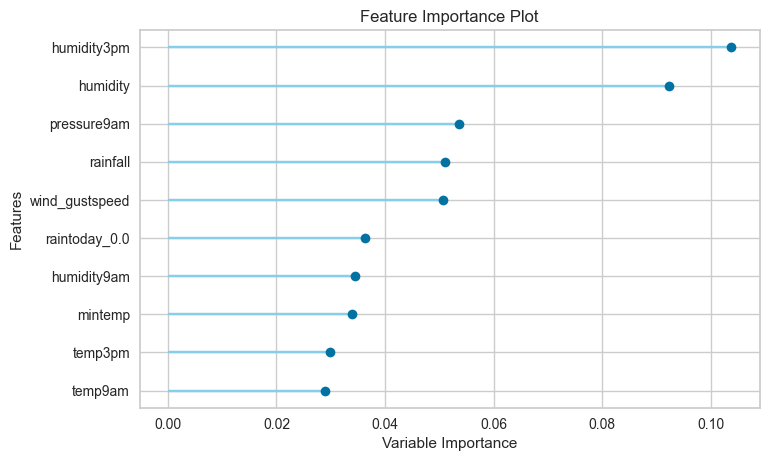

In [12]:
plot_model(best, plot='feature')

In [13]:
# return top 3 models based on 'Accuracy'
top3 = compare_models(n_select = 3, sort = 'AUC', round = 2)
allDone()
print(top3)
allDone()
# compare specific models
#best_specific = compare_models(include = ['dt','rf','xgboost'])
# blacklist certain models
#best_specific = compare_models(exclude = ['catboost', 'svm'])

save_model(top3, 'top3')
logs = get_logs(save=True)
allDone()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.85,0.90,0.66,0.72,0.69,0.59,0.59,0.86
et,Extra Trees Classifier,0.85,0.89,0.63,0.75,0.68,0.59,0.59,1.04
lightgbm,Light Gradient Boosting Machine,0.85,0.89,0.62,0.74,0.67,0.58,0.58,0.49
xgboost,Extreme Gradient Boosting,0.84,0.88,0.61,0.73,0.67,0.57,0.57,1.93
lr,Logistic Regression,0.79,0.87,0.78,0.57,0.66,0.52,0.53,1.50
gbc,Gradient Boosting Classifier,0.83,0.87,0.64,0.67,0.66,0.54,0.54,1.75
lda,Linear Discriminant Analysis,0.79,0.87,0.78,0.57,0.66,0.52,0.53,0.47
ada,Ada Boost Classifier,0.81,0.85,0.64,0.62,0.63,0.50,0.50,0.67
knn,K Neighbors Classifier,0.71,0.81,0.80,0.46,0.58,0.38,0.41,0.76
nb,Naive Bayes,0.64,0.76,0.78,0.40,0.52,0.28,0.32,0.20


[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=4267, verbose=0,
                       warm_start=False), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                     oob_score=F

Transformation Pipeline and Model Succesfully Saved


## Your Model

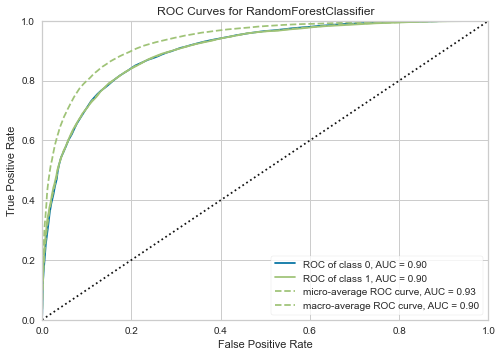

In [14]:
model_best = create_model(best,fold = 10)
plot_model(model_best)

In [15]:
model_best_results = pull()
top3_results = pull()

allDone()

## Tune Model

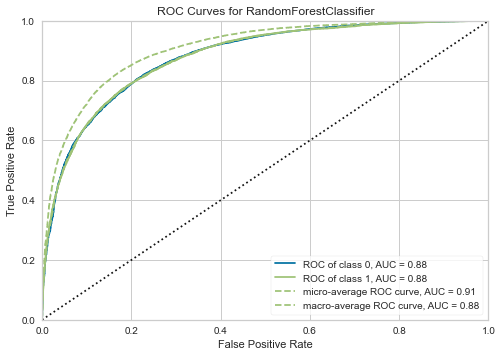

Transformation Pipeline and Model Succesfully Saved


In [16]:
tuned_model = tune_model(model_best, optimize = 'AUC', n_iter = 50)
allDone()
plot_model(tuned_model)
allDone()

save_model(tuned_model, 'tuned_model')
logs = get_logs(save=True)
allDone()

In [17]:
plot_model(tuned_model, plot = 'parameter')
allDone()
logs = get_logs(save=True)

allDone()

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,gini
max_depth,10
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0001
min_impurity_split,None


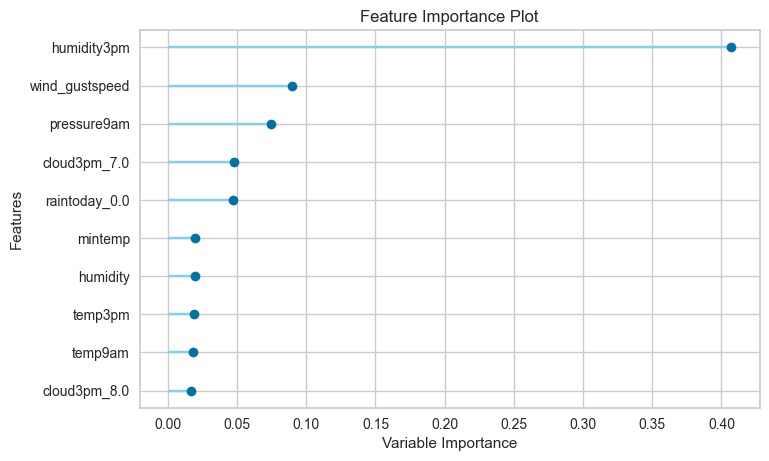

In [18]:
plot_model(tuned_model, plot='feature')
allDone()
logs = get_logs(save=True)

allDone()

## Ensemble Model

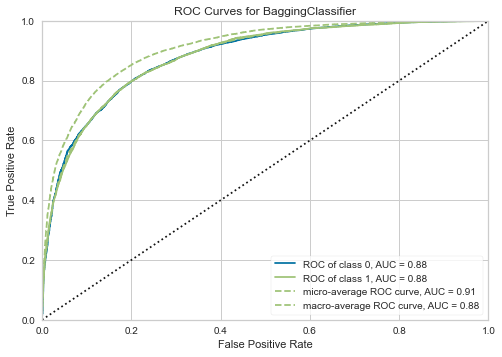

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=30, n_jobs=5, oob_score=False,
                       random_state=1626225108, verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
              

In [19]:
# With Bagging
bagged_tuned_model = ensemble_model(tuned_model, method = 'Bagging', n_estimators = 10) # n_estimators = 100
allDone()
plot_model(bagged_tuned_model)
allDone()
print(bagged_tuned_model.estimators_)

save_model(bagged_tuned_model, 'bagged_tuned_model')
allDone()
logs = get_logs(save=True)

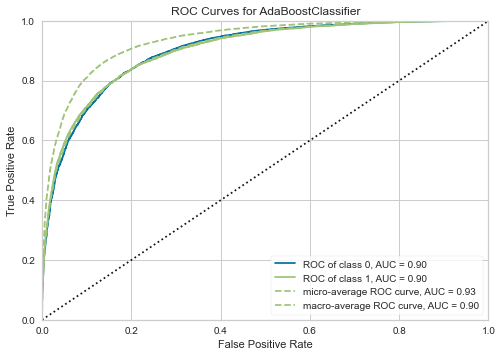

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=30, n_jobs=5, oob_score=False,
                       random_state=118736613, verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
               

Transformation Pipeline and Model Succesfully Saved


In [20]:
# With Boosting
boosted_tuned_model = ensemble_model(tuned_model, method = 'Boosting', n_estimators = 10) # n_estimators = 100
allDone()
plot_model(boosted_tuned_model)
allDone()
print(boosted_tuned_model.estimators_)
allDone()
logs = get_logs(save=True)

save_model(boosted_tuned_model, 'boosted_tuned_model')
allDone()
logs = get_logs(save=True)

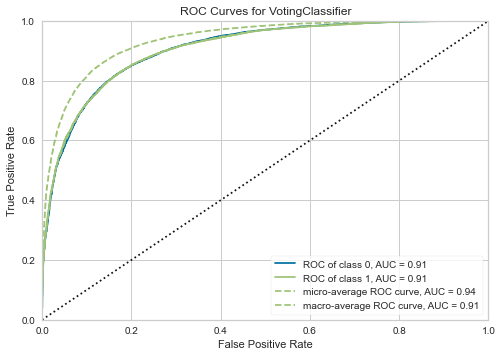

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=4267, verbose=0,
                       warm_start=False), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                     oob_score=F

Transformation Pipeline and Model Succesfully Saved


In [21]:
# Blend Models
blender = blend_models(top3)
plot_model(blender)
allDone()
print(blender.estimators_)
allDone()

save_model(blender, 'blender')
allDone()
logs = get_logs(save=True)



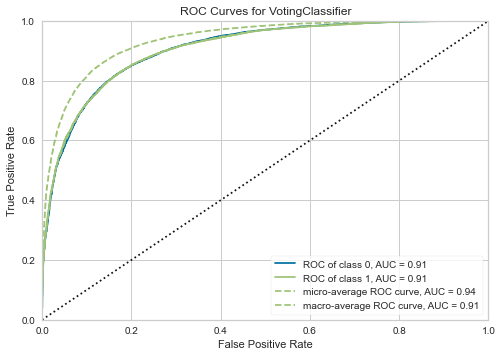

Transformation Pipeline and Model Succesfully Saved


In [22]:
blender_specific = blend_models(estimator_list = compare_models(n_select = 3), method = 'hard')
plot_model(blender)
allDone()

save_model(blender_specific, 'blender_specific')
allDone()
logs = get_logs(save=True)

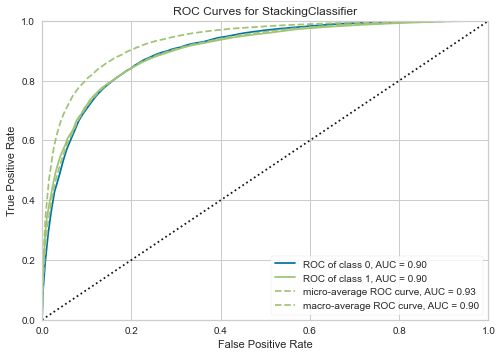

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                     oob_score=False, random_state=4267, verbose=0,
                     warm_start=False), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=5, num_leaves=31, objective=None,
               random_state=4267, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]


Transformation Pipeline and Model Succesfully Saved


In [23]:
# Stack Model
stacker_top3 = stack_models(estimator_list = top3[1:], meta_model = top3[0], restack = True)
allDone()
plot_model(stacker_top3)
allDone()
print(stacker_top3.estimators_)
allDone()


save_model(stacker_top3, 'stacker_top3')
allDone()
logs = get_logs(save=True)

## Calibrate Models

### Tuned Model

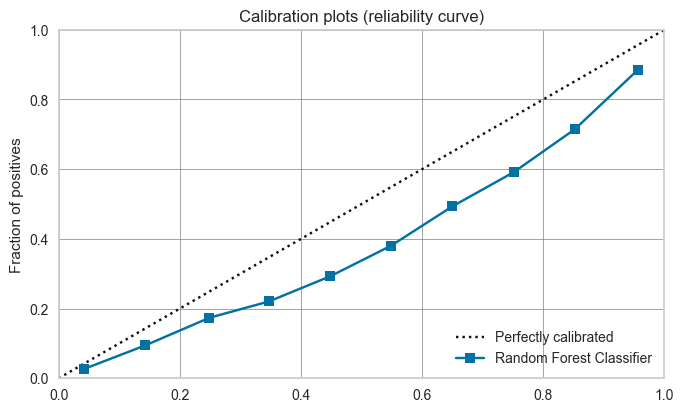

In [25]:
plot_model(tuned_model, plot='calibration')

#plot_model(blender_specific, plot='calibration')

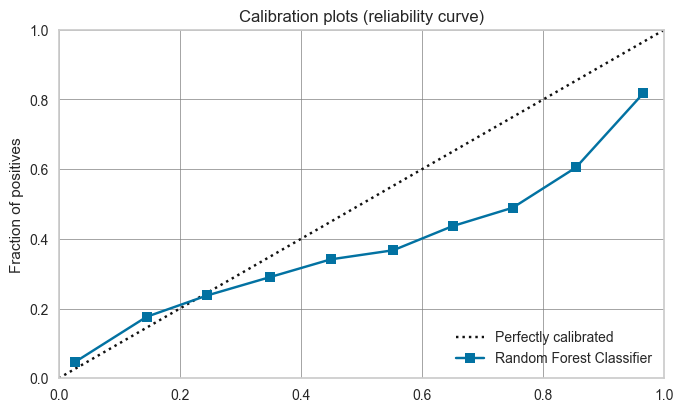

Transformation Pipeline and Model Succesfully Saved


In [49]:
calibrated_tuned_model = calibrate_model(tuned_model)
allDone()
plot_model(calibrated_tuned_model, plot='calibration')
logs = get_logs(save=True)

save_model(calibrated_tuned_model, 'calibrated_tuned_model')
logs = get_logs(save=True)
allDone()

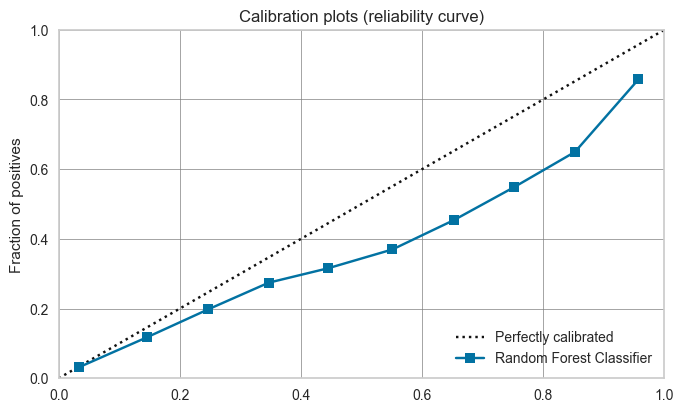

Transformation Pipeline and Model Succesfully Saved


In [50]:
calibrated_tuned_model_isotonic = calibrate_model(tuned_model, method = 'isotonic')
allDone()
plot_model(calibrated_tuned_model_isotonic, plot='calibration')
logs = get_logs(save=True)

save_model(calibrated_tuned_model_isotonic, 'calibrated_tuned_model_isotonic')
logs = get_logs(save=True)
allDone()

### bagged_tuned_model

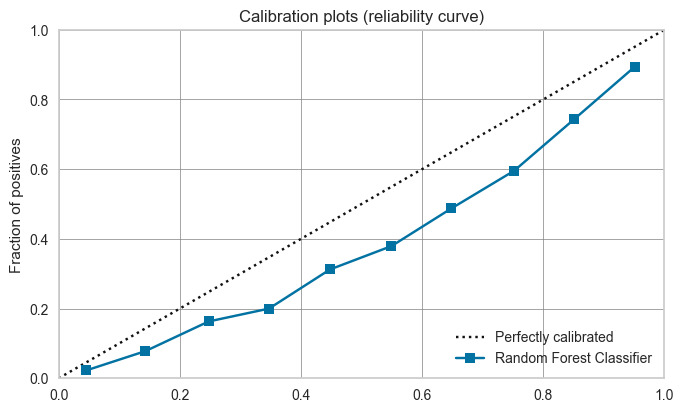

In [69]:
plot_model(bagged_tuned_model, plot='calibration')

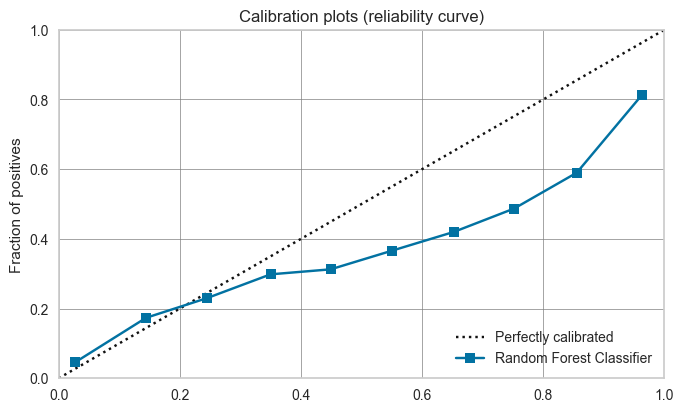

Transformation Pipeline and Model Succesfully Saved


In [51]:
calibrated_bagged_tuned_model = calibrate_model(bagged_tuned_model)
allDone()
plot_model(calibrated_bagged_tuned_model, plot='calibration')
logs = get_logs(save=True)

save_model(calibrated_bagged_tuned_model, 'calibrated_bagged_tuned_model')
logs = get_logs(save=True)
allDone()

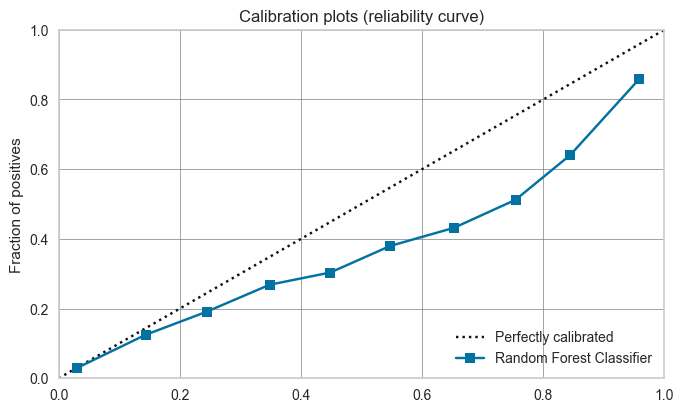

Transformation Pipeline and Model Succesfully Saved


In [72]:
calibrated_bagged_tuned_model_isotonic = calibrate_model(bagged_tuned_model, method = 'isotonic')
allDone()
plot_model(calibrated_bagged_tuned_model_isotonic, plot='calibration')
logs = get_logs(save=True)

save_model(calibrated_bagged_tuned_model_isotonic, 'calibrated_bagged_tuned_model_isotonic')
logs = get_logs(save=True)
allDone()

### Stacker_top3

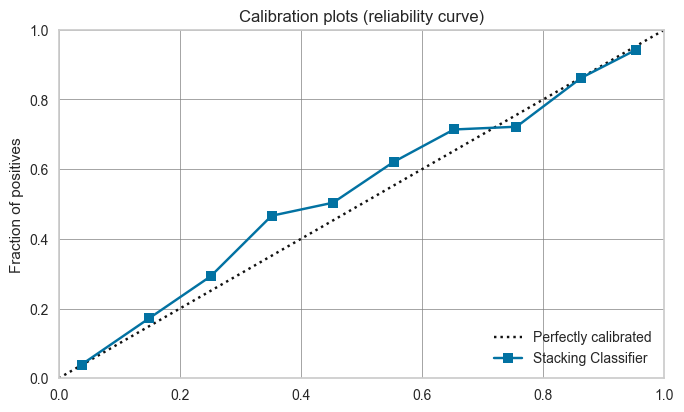

In [70]:
plot_model(stacker_top3, plot='calibration')

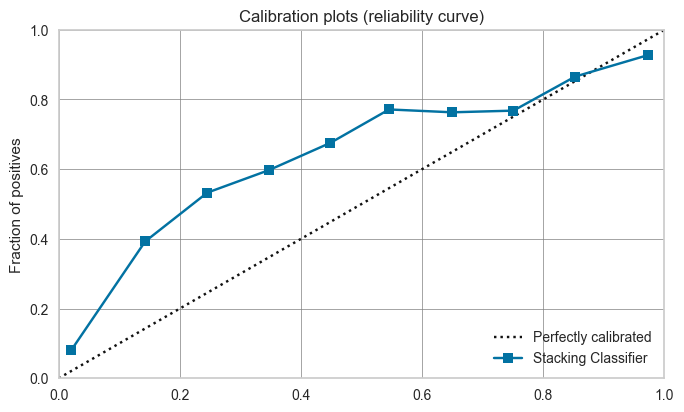

Transformation Pipeline and Model Succesfully Saved


In [52]:
calibrated_stacker_top3 = calibrate_model(stacker_top3)
allDone()
plot_model(calibrated_stacker_top3, plot='calibration')
logs = get_logs(save=True)

save_model(calibrated_stacker_top3, 'calibrated_stacker_top3')
logs = get_logs(save=True)
allDone()

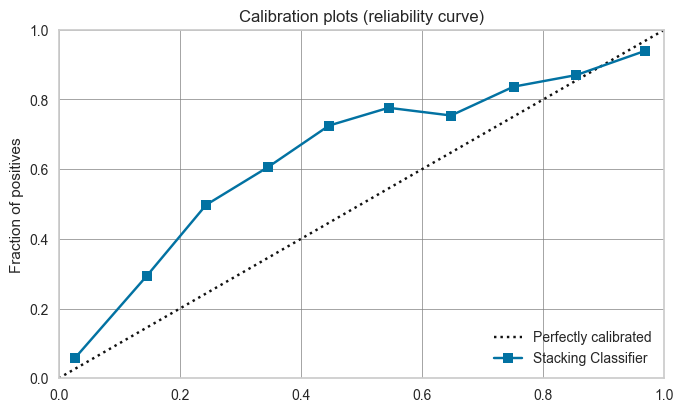

Transformation Pipeline and Model Succesfully Saved


In [53]:
calibrated_stacker_top3_isotonic = calibrate_model(stacker_top3, method = 'isotonic')
allDone()
plot_model(calibrated_stacker_top3_isotonic, plot='calibration')
logs = get_logs(save=True)

save_model(calibrated_stacker_top3_isotonic, 'calibrated_stacker_top3_isotonic')
logs = get_logs(save=True)
allDone()

### Boosted Tuned Model

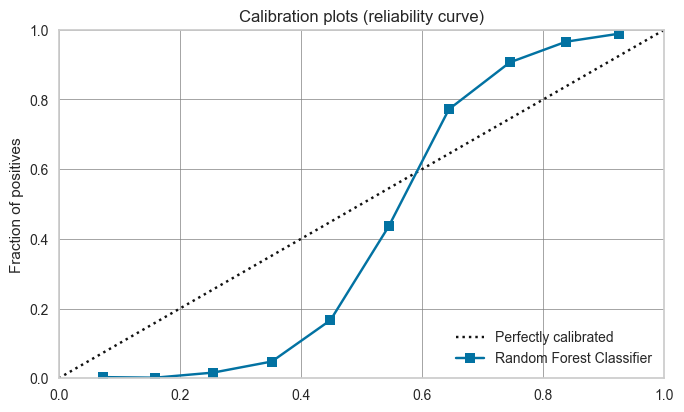

In [68]:
plot_model(boosted_tuned_model, plot='calibration')
allDone()

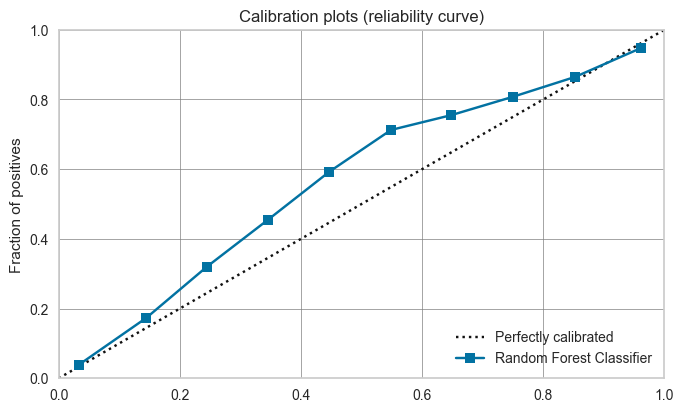

Transformation Pipeline and Model Succesfully Saved


In [54]:
calibrated_boosted_tuned_model = calibrate_model(boosted_tuned_model)
allDone()
plot_model(calibrated_boosted_tuned_model, plot='calibration')
logs = get_logs(save=True)

save_model(calibrated_boosted_tuned_model, 'calibrated_boosted_tuned_model')
logs = get_logs(save=True)
allDone()

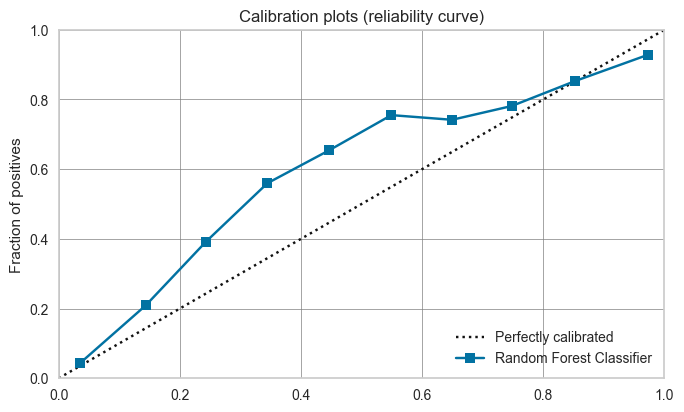

Transformation Pipeline and Model Succesfully Saved


In [56]:
calibrated_boosted_tuned_model_isotonic = calibrate_model(boosted_tuned_model, method = 'isotonic')
allDone()
plot_model(calibrated_boosted_tuned_model_isotonic, plot='calibration')
logs = get_logs(save=True)

save_model(calibrated_boosted_tuned_model_isotonic, 'calibrated_boosted_tuned_model_isotonic')
logs = get_logs(save=True)
allDone()

## Final Plot

In [34]:
#plot_model(calibrated_tuned_model, plot='feature')

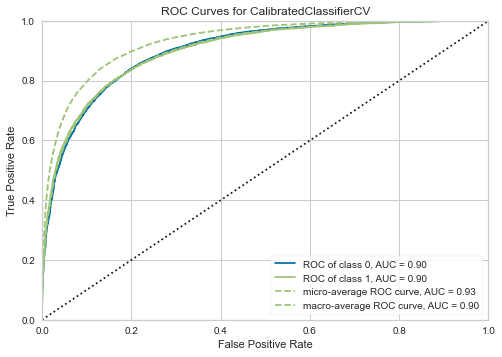

In [66]:
plot_model(calibrated_boosted_tuned_model) 

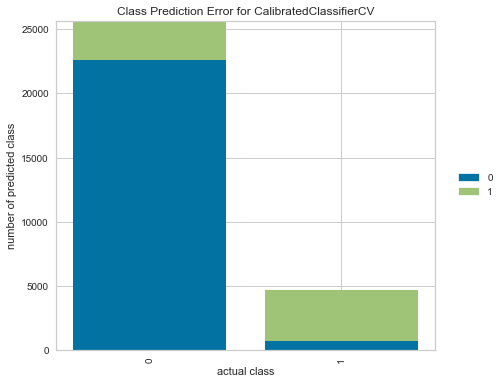

In [67]:
plot_model(calibrated_boosted_tuned_model, plot='error')

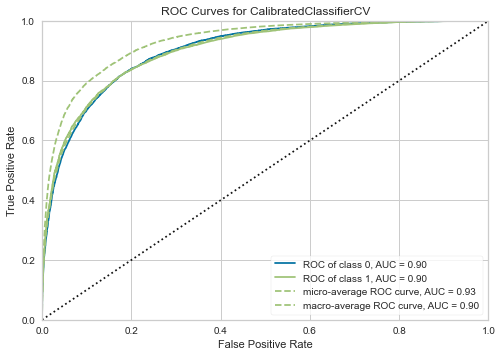

In [57]:
plot_model(calibrated_boosted_tuned_model_isotonic)

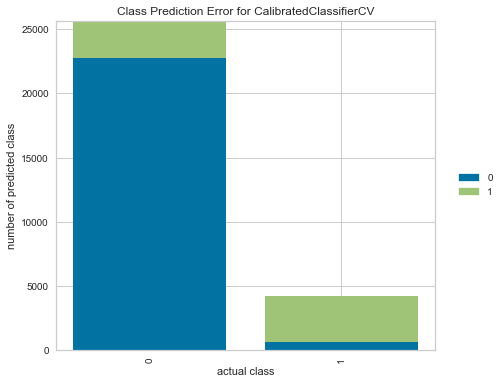

In [58]:
plot_model(calibrated_boosted_tuned_model_isotonic, plot='error')

## Optimize threshold

In [61]:
optimize_threshold(calibrated_boosted_tuned_model, true_negative = 1500, false_negative = -5000)
allDone()
logs = get_logs(save=True)

Optimized Probability Threshold: 0.20720000000000002 | Optimized Cost Function: 21707500


## Predict

In [74]:
pred_holdout_calibrated_boosted_tuned_model = predict_model(calibrated_boosted_tuned_model)  #, probability_threshold = 0.0754)
allDone()

save_model(pred_holdout_calibrated_boosted_tuned_model, 'pred_holdout_calibrated_boosted_tuned_model')
logs = get_logs(save=True)
allDone()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8543,0.9026,0.5120,0.8413,0.6366,0.5521,0.5788


Transformation Pipeline and Model Succesfully Saved


In [75]:
pred_holdout_calibrated_boosted_tuned_model_optimize_threshold = predict_model(calibrated_boosted_tuned_model, probability_threshold = 0.2072)
allDone()

save_model(pred_holdout_calibrated_boosted_tuned_model_optimize_threshold, 'pred_holdout_calibrated_boosted_tuned_model_optimize_threshold')
logs = get_logs(save=True)
allDone()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8284,0.9026,0.8047,0.6200,0.7004,0.5830,0.5927


Transformation Pipeline and Model Succesfully Saved


In [ ]:
#plot_importance(pred_holdout_calibrated_tuned_model, importance_type='gain')

In [ ]:
# Predict on Unseen Data

In [77]:
data_unseen

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,...,temp,humidity,precipitation3pm,precipitation9am,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm
0,2009-05-06,Albury,4.1,19.3,0.0,NaN,NaN,82.0,49.0,1028.5,...,25.16,60.80000,21,9.638515,12,20.0,1,14,6.0,7.0
1,2009-05-13,Albury,3.6,15.1,0.0,NaN,NaN,86.0,61.0,1018.4,...,20.12,3.57242,5,16.955698,14,28.0,9,13,4.0,17.0
2,2009-06-21,Albury,7.0,17.0,1.6,NaN,NaN,99.0,71.0,1021.9,...,22.40,87.20000,6,6.922022,1,46.0,7,1,4.0,20.0
3,2009-06-27,Albury,8.4,11.9,0.0,NaN,NaN,79.0,81.0,1007.8,...,16.28,99.20000,9,12.501754,10,22.0,9,9,7.0,6.0
4,2009-07-01,Albury,8.3,13.3,8.4,NaN,NaN,85.0,68.0,1006.5,...,17.96,83.60000,6,12.095033,7,52.0,3,7,20.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,2017-06-12,Uluru,5.1,19.7,0.0,NaN,NaN,56.0,29.0,1028.5,...,25.64,36.80000,5,9.616227,0,46.0,2,0,13.0,17.0
2216,2017-06-13,Uluru,2.5,21.2,0.0,NaN,NaN,57.0,32.0,1027.2,...,27.44,40.40000,16,2.087524,1,35.0,2,0,17.0,19.0
2217,2017-06-14,Uluru,2.3,21.4,0.0,NaN,NaN,60.0,28.0,1026.9,...,27.68,35.60000,9,7.138953,9,22.0,9,10,11.0,7.0
2218,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,53.0,24.0,1021.0,...,34.28,30.80000,12,0.985551,3,37.0,9,14,9.0,9.0


In [80]:
predictions = predict_model(calibrated_boosted_tuned_model, data = data_unseen, probability_threshold = 0.2072)

In [81]:
predictions

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,...,precipitation3pm,precipitation9am,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,Label,Score
0,2009-05-06,Albury,4.1,19.3,0.0,NaN,NaN,82.0,49.0,1028.5,...,21,9.638515,12,20.0,1,14,6.0,7.0,0,0.9905
1,2009-05-13,Albury,3.6,15.1,0.0,NaN,NaN,86.0,61.0,1018.4,...,5,16.955698,14,28.0,9,13,4.0,17.0,0,0.8924
2,2009-06-21,Albury,7.0,17.0,1.6,NaN,NaN,99.0,71.0,1021.9,...,6,6.922022,1,46.0,7,1,4.0,20.0,1,0.5199
3,2009-06-27,Albury,8.4,11.9,0.0,NaN,NaN,79.0,81.0,1007.8,...,9,12.501754,10,22.0,9,9,7.0,6.0,1,0.5561
4,2009-07-01,Albury,8.3,13.3,8.4,NaN,NaN,85.0,68.0,1006.5,...,6,12.095033,7,52.0,3,7,20.0,22.0,1,0.7737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,2017-06-12,Uluru,5.1,19.7,0.0,NaN,NaN,56.0,29.0,1028.5,...,5,9.616227,0,46.0,2,0,13.0,17.0,0,0.9958
2216,2017-06-13,Uluru,2.5,21.2,0.0,NaN,NaN,57.0,32.0,1027.2,...,16,2.087524,1,35.0,2,0,17.0,19.0,0,0.9956
2217,2017-06-14,Uluru,2.3,21.4,0.0,NaN,NaN,60.0,28.0,1026.9,...,9,7.138953,9,22.0,9,10,11.0,7.0,0,0.9984
2218,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,53.0,24.0,1021.0,...,12,0.985551,3,37.0,9,14,9.0,9.0,0,0.9959


In [83]:
predictions.describe().T

,count,mean,std,min,25%,50%,75%,max
mintemp,2203.0,8.262233,5.379202,-7.000000,4.500000,8.100000,11.600000,25.900000
maxtemp,2213.0,18.100407,5.231994,-1.400000,14.700000,17.700000,20.800000,35.500000
rainfall,2202.0,2.139328,6.187954,0.000000,0.000000,0.000000,1.000000,113.800000
evaporation,1171.0,2.776857,1.971706,0.000000,1.400000,2.200000,3.800000,17.200000
sunshine,1023.0,5.856109,3.448645,0.000000,2.800000,6.200000,9.100000,11.200000
humidity9am,2185.0,77.510297,16.718089,13.000000,67.000000,79.000000,92.000000,100.000000
humidity3pm,2138.0,58.605706,18.683140,7.000000,45.000000,58.000000,71.000000,100.000000
pressure9am,1997.0,1020.817126,7.469590,987.900000,1016.200000,1021.000000,1026.100000,1039.200000
pressure3pm,1999.0,1018.413357,7.337166,989.200000,1013.900000,1018.500000,1023.800000,1035.800000
cloud9am,1344.0,4.750744,2.900882,0.000000,1.000000,6.000000,7.000000,8.000000


## Finalize Model

In [82]:
final_calibrated_boosted_tuned_model = finalize_model(calibrated_boosted_tuned_model)
allDone()
save_model(final_calibrated_boosted_tuned_model, 'final_calibrated_boosted_tuned_model')
allDone()
logs = get_logs(save=True)

Transformation Pipeline and Model Succesfully Saved


In [ ]:
#get_system_logs() 

# See Mflow

In [ ]:
# See MLflow: Run the code and then open localhost:5000 in another tab from your web browser
!mlflow ui

# Interpret Model

In [ ]:
interpret_model(tuned_model)
allDone()
interpret_model(tuned_model, plot = 'correlation')
allDone()
interpret_model(tuned_model, plot = 'reason', observation = 10)
allDone()
logs = get_logs(save=True)

allDone()